# SiebenApp Rendering v3.0

In [229]:
# Rendering defaults
WIDTH = 3

In [3]:
import matplotlib.pyplot as plt
from typing import Dict, List, Set

## Use existing SiebenApp structures

In SiebenApp, we use the following structures in rendering algorithm:

In [52]:
from dataclasses import dataclass, field, replace
from enum import IntEnum
from typing import Any, Union, Optional

In [13]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For leegacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


Our goal is to recreate algorithm above using these structures, not just raw dicts.

In [28]:
from random import randint

In [167]:
sample_result = RenderResult(
    [
        RenderRow(k, k, f"Goal {k}", True, not es,
                  [(e, EdgeType.PARENT) for e in es], {})
        for k, es in edges.items()
    ],
    node_opts={k: {} for k in edges},
    select=(1, 1),
    roots={1},
)

In [168]:
sample_result

RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(g

In [193]:
def draw1(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

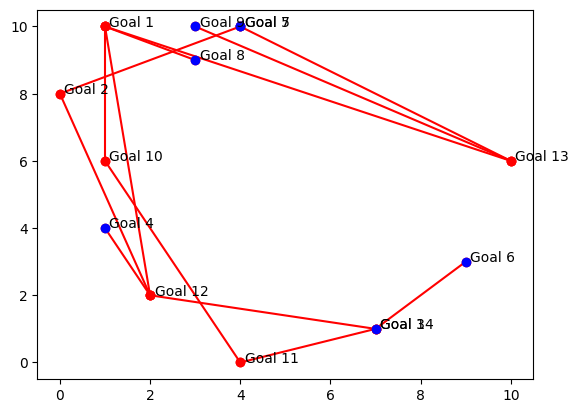

In [173]:
draw1(sample_result)

In [78]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

def tube1(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    
    return RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots), new_roots, layers + [new_layer]

In [174]:
rr1, roots1, layers1 = tube1(sample_result, list(sample_result.roots), [])
rr1, roots1, layers1

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

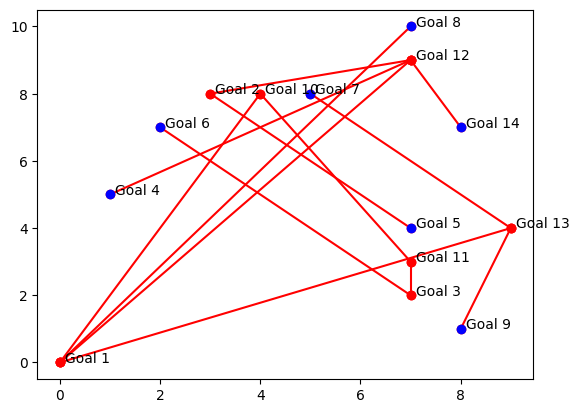

In [177]:
draw1(rr1, min_row=1)

In [90]:
rr2, roots2, layers2 = tube1(rr1, roots1, layers1)
rr2, roots2, layers2

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

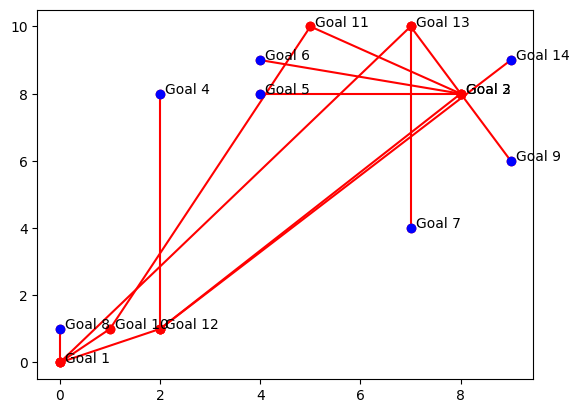

In [178]:
draw1(rr2, min_row=2)

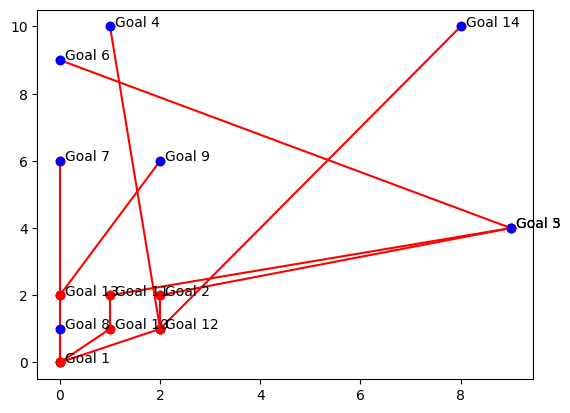

In [179]:
rr3, roots3, layers3 = tube1(rr2, roots2, layers2)
draw1(rr3, min_row=3)

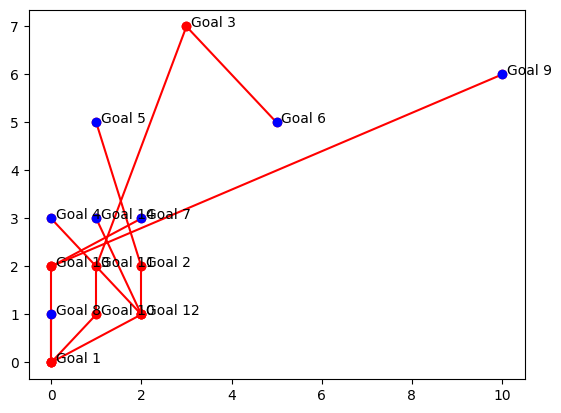

In [180]:
rr4, roots4, layers4 = tube1(rr3, roots3, layers3)
draw1(rr4, min_row=4)

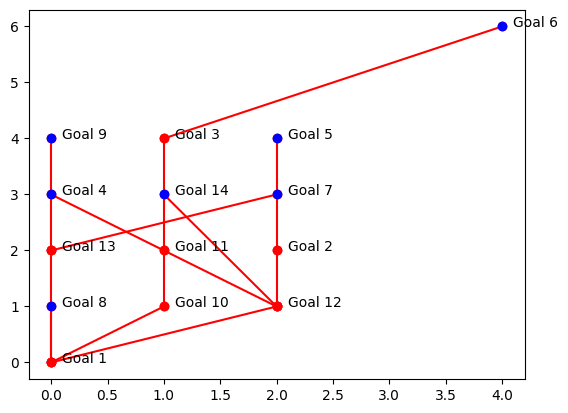

In [181]:
rr5, roots5, layers5 = tube1(rr4, roots4, layers4)
draw1(rr5, min_row=6)

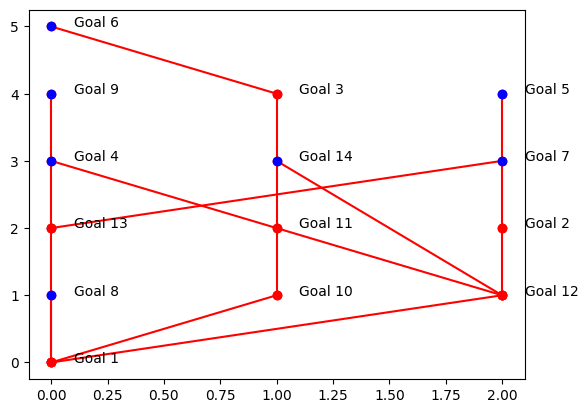

In [96]:
rr6, roots6, layers6 = tube1(rr5, roots5, layers5)
draw1(rr6)

In [97]:
roots6, layers6

([], [[1], [8, 10, 12], [13, 11, 2], [4, 14, 7], [9, 3, 5], [6]])

Variable `roots6` is empty, so we've finished.

To summarize, we need a following fn to put all goals onto layers:

In [98]:
def split_to_layers(rr: RenderResult) -> RenderResult:
    roots = list(rr.roots)
    layers = []
    while roots:
        rr, roots, layers = tube1(rr, roots, layers)
    return rr

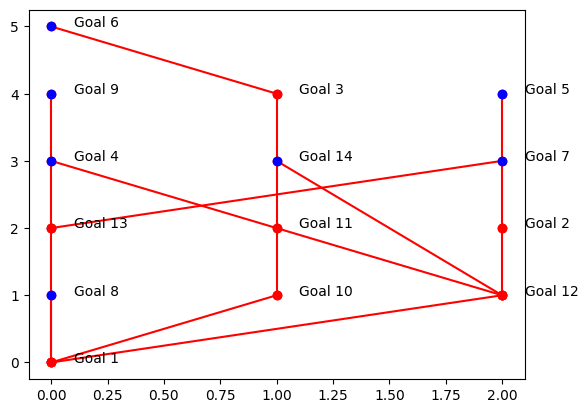

In [99]:
sample_with_layers = split_to_layers(sample_result)
draw1(sample_with_layers)

## Force-based column adjusting

The next step is column adjusting. We want to minimize edge intersections. We try to use force-based approach. For every node, we need to calculate an imaginary "force" that's applied to it from connected nodes. This force may pull given node to the left or to the right.

An important questions is whether should we consider vertical distance (a difference in layers) or not. The following possible models come into my mind:

1. "Neutral": we do not consider vertical distance, just horisontal distance solely.
2. "Gravitational": the more vertical distance is, the **less** a horisontal distance from this node contributes to the final result.
3. "Rubber": the more vertical distance is, the **more** a horisontal distance from this node contributes to the final result.

Let's take a look to the current differences of our graph.

In [198]:
def avg(vals):
    return sum(vals) / len(vals)

def shift_neutral(ds):
    return avg([d[1] for d in ds])

def calc_shift(rr: RenderResult, shift_fn):
    connected: Dict[int, Set[int]] = {row.goal_id: set() for row in rr.rows}
    for row in rr.rows:
        for e in row.edges:
            connected[e[0]].add(row.goal_id)
            connected[row.goal_id].add(e[0])

    result = {}
    for row in rr.rows:
        goal_id = row.goal_id
        opts = rr.node_opts[goal_id]
        row_, col_ = opts['row'], opts['col']
        deltas = [
            (rr.node_opts[c]['row'] - row_,
             rr.node_opts[c]['col'] - col_)
            for c in connected[goal_id]
        ]
        result[goal_id] = shift_fn(deltas)
    return result

In [199]:
calc_shift(sample_with_layers, shift_neutral)

{1: 0.75,
 2: 0.0,
 3: -0.5,
 4: 2.0,
 5: 0.0,
 6: 1.0,
 7: -2.0,
 8: 0.0,
 9: 0.0,
 10: -0.5,
 11: 0.0,
 12: -1.25,
 13: 0.6666666666666666,
 14: 1.0}

Let's proceed with a "neutral shift" for now. Having shifts calculated, we apply a _half_ of horisontal shift for each of nodes. Why just a half? Because every shift is a result of _mutual_ interaction between nodes. If we move two nodes for the full length of shift towards each other, they could simply swap their columns, and new distance between them would become non-null again.

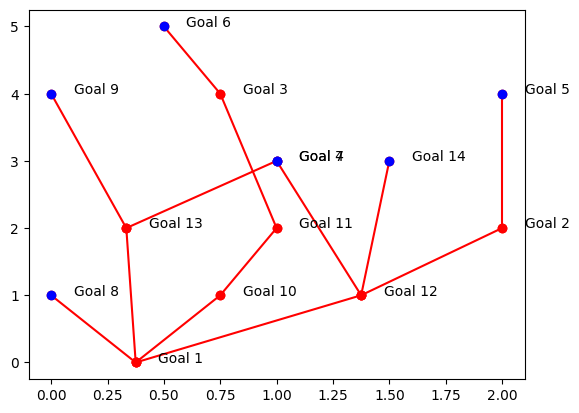

In [141]:
def adjust_horisontal(rr: RenderResult, mult):
    deltas = calc_shift(rr, shift_neutral)
    new_opts = {
        goal_id: opts | {"col": opts["col"] + (mult * deltas[goal_id])}
        for goal_id, opts in rr.node_opts.items()
    }
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

draw1(adjust_horisontal(sample_with_layers, 0.5))

Well, a very little was changed. Only "Goal 7" and "Goal 14" have swapped their positions. Looks like we should try to apply shift more eagerly.

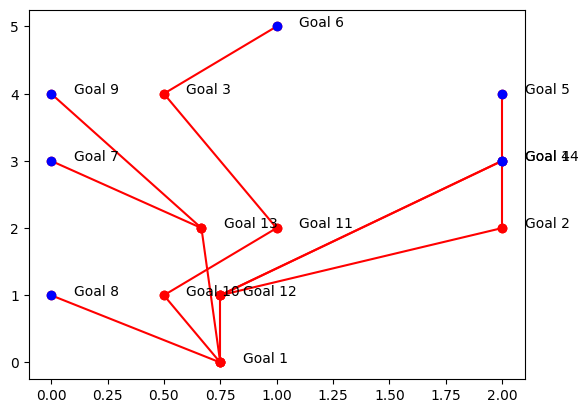

In [143]:
draw1(adjust_horisontal(sample_with_layers, 1.0))

Not a big difference. But let's try to run it one or more times recursively.

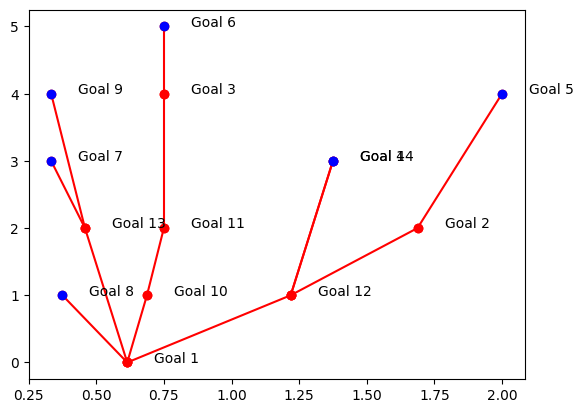

In [144]:
sample_adj1_1 = adjust_horisontal(sample_with_layers, 1.0)
sample_adj1_2 = adjust_horisontal(sample_adj1_1, 0.5)
draw1(sample_adj1_2)

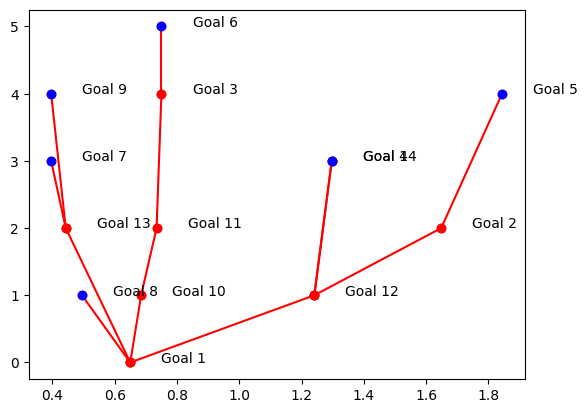

In [147]:
sample_adj1_3 = adjust_horisontal(sample_adj1_2, 0.5)
draw1(sample_adj1_3)

That looks much better! It even resemles an original graph, except with a "normalized" number of nodes on each level. Also, for such a simple graph we only need to apply 2 adjustment steps, with decreasing coefficients 1.0 and 0.5.

Now, we need to return back to integer-valued columns. How could we do it? We'll try to _sort_ nodes in each row by their new "col" value and then use its index as a new col.

In [253]:
def normalize_cols(rr: RenderResult) -> RenderResult:
    order0 = {}
    for goal_id, opts in rr.node_opts.items():
        row, col = opts["row"], opts["col"]
        if row not in order0:
            order0[row] = []
        order0[row].append((col, goal_id))
    # print("order0: ", order0)
    order1 = {}
    for layer, tuples in order0.items():
        non_empty = list(round(t[0]) for t in tuples)
        need_drop = len(tuples) - len(set(non_empty))
        empty = {x for x in range(WIDTH)}.difference(non_empty)
        for i in range(need_drop):
            empty.pop()
        # print(f"{layer}: non-empty {non_empty}, empty {empty}, dropped {need_drop}")
        order1[layer] = tuples + [(e, -10) for e in empty]
    # print("order1: ", order1)
    order2 = {k: sorted(v) for k, v in order1.items()}
    # print("order2: ", order2)
    indexed0 = {k: [t[1] for t in v] for k, v in order2.items()}
    # print("indexed0: ", indexed0)
    indexed1 = {}
    for layer in indexed0.values():
        for i, goal_id in enumerate(layer):
            if goal_id > 0:
                indexed1[goal_id] = i
    # print("indexed1: ", indexed1)
    new_opts = {
        goal_id: opts | {"col": indexed1[goal_id]}
        for goal_id, opts in rr.node_opts.items()
    }
    # print(new_opts)
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

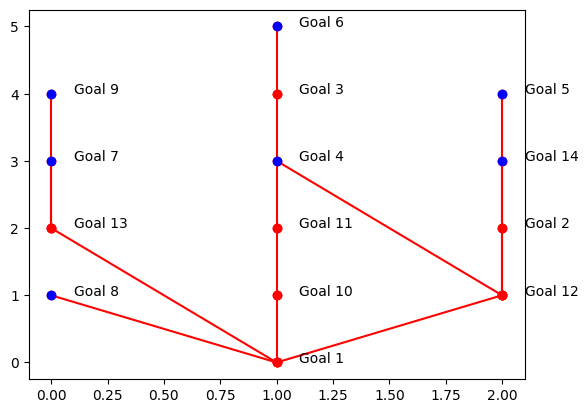

In [239]:
draw1(normalize_cols(sample_adj1_2))

**WOOT!**

Now it's much better than the unadjusted version!

An important distinction to the _current_ rendering algorithms within SiebenApp is lack of "fake goals" (actually representing intersection of long edges and horisontal layers). Probably, this change is even crucial. Without fake goals on this stage, we gain two important advantages:

1. A total number of goals to work with is reduced (in other words, we need to perform less computations).
2. An overall "force effect" doesn't depend on the number of levels between two connected nodes. It affects both nodes immediately, and that's great.

We would need to add fake goals at the next stage, when we would draw edges bypassing nodes. But tree adjustment works better without them.

## Try on real world example

QA-3897 _(just don't ask)_

In [191]:
rrr = RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='node 1', is_open=True, is_switchable=False, edges=[(2, EdgeType.PARENT), (3, EdgeType.PARENT), (4, EdgeType.PARENT), (5, EdgeType.PARENT), (40, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='node 2', is_open=True, is_switchable=True, edges=[(43, EdgeType.PARENT), (44, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='node 3', is_open=True, is_switchable=False, edges=[(6, EdgeType.BLOCKER), (7, EdgeType.BLOCKER), (8, EdgeType.BLOCKER), (30, EdgeType.PARENT), (37, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='node 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='node 5', is_open=True, is_switchable=False, edges=[(6, EdgeType.PARENT), (7, EdgeType.PARENT), (8, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=6, raw_id=6, name='node 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='node 7', is_open=True, is_switchable=False, edges=[(9, EdgeType.BLOCKER), (16, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=8, raw_id=8, name='node 8', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=9, raw_id=9, name='node 9', is_open=True, is_switchable=False, edges=[(10, EdgeType.PARENT), (11, EdgeType.PARENT), (12, EdgeType.PARENT), (13, EdgeType.PARENT), (14, EdgeType.PARENT), (15, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=10, raw_id=10, name='node 10', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=11, raw_id=11, name='node 11', is_open=False, is_switchable=True, edges=[(51, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=12, raw_id=12, name='node 12', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=13, raw_id=13, name='node 13', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=14, raw_id=14, name='node 14', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=15, raw_id=15, name='node 15', is_open=True, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=16, raw_id=16, name='node 16', is_open=False, is_switchable=True, edges=[(17, EdgeType.PARENT), (18, EdgeType.PARENT), (19, EdgeType.PARENT), (20, EdgeType.PARENT), (24, EdgeType.PARENT), (25, EdgeType.PARENT), (26, EdgeType.PARENT), (27, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=17, raw_id=17, name='node 17', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=18, raw_id=18, name='node 18', is_open=False, is_switchable=False, edges=[(23, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=19, raw_id=19, name='node 19', is_open=False, is_switchable=False, edges=[(21, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=20, raw_id=20, name='node 20', is_open=False, is_switchable=False, edges=[(21, EdgeType.PARENT), (22, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=21, raw_id=21, name='node 21', is_open=False, is_switchable=False, edges=[(38, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=22, raw_id=22, name='node 22', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=23, raw_id=23, name='node 23', is_open=False, is_switchable=False, edges=[(38, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=24, raw_id=24, name='node 24', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=25, raw_id=25, name='node 25', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=26, raw_id=26, name='node 26', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=27, raw_id=27, name='node 27', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=28, raw_id=28, name='node 28', is_open=False, is_switchable=True, edges=[(29, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=29, raw_id=29, name='node 29', is_open=False, is_switchable=False, edges=[(45, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=30, raw_id=30, name='node 30', is_open=True, is_switchable=True, edges=[(31, EdgeType.PARENT), (32, EdgeType.PARENT), (33, EdgeType.PARENT), (34, EdgeType.PARENT), (35, EdgeType.PARENT), (36, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=31, raw_id=31, name='node 31', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=32, raw_id=32, name='node 32', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=33, raw_id=33, name='node 33', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=34, raw_id=34, name='node 34', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=35, raw_id=35, name='node 35', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=36, raw_id=36, name='node 36', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=37, raw_id=37, name='node 37', is_open=True, is_switchable=False, edges=[(9, EdgeType.PARENT), (16, EdgeType.PARENT), (28, EdgeType.PARENT), (42, EdgeType.PARENT), (46, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=38, raw_id=38, name='node 38', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=39, raw_id=39, name='node 39', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=40, raw_id=40, name='node 40', is_open=True, is_switchable=False, edges=[(39, EdgeType.PARENT), (41, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=41, raw_id=41, name='node 41', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=42, raw_id=42, name='node 42', is_open=False, is_switchable=True, edges=[(43, EdgeType.BLOCKER), (44, EdgeType.BLOCKER), (49, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=43, raw_id=43, name='node 43', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=44, raw_id=44, name='node 44', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=45, raw_id=45, name='node 45', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=46, raw_id=46, name='node 46', is_open=False, is_switchable=True, edges=[(47, EdgeType.PARENT), (48, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=47, raw_id=47, name='node 47', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=48, raw_id=48, name='node 48', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=49, raw_id=49, name='node 49', is_open=False, is_switchable=False, edges=[(50, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=50, raw_id=50, name='node 50', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=51, raw_id=51, name='node 51', is_open=False, is_switchable=False, edges=[], attrs={})], select=(1, 1), roots={1}, node_opts={1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26:{}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}})

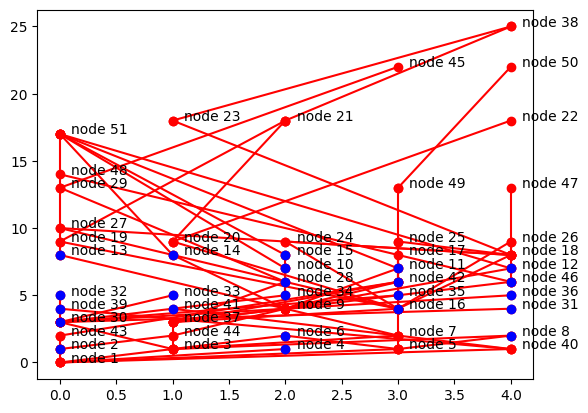

In [241]:
WIDTH = 5
rrr1 = split_to_layers(rrr)
draw1(rrr1)

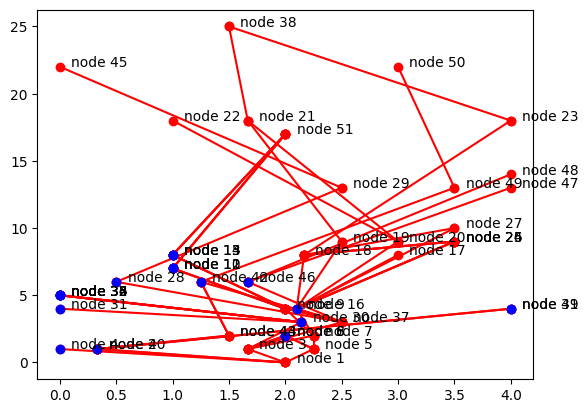

In [201]:
rrr2 = adjust_horisontal(rrr1, 1.0)
draw1(rrr2)

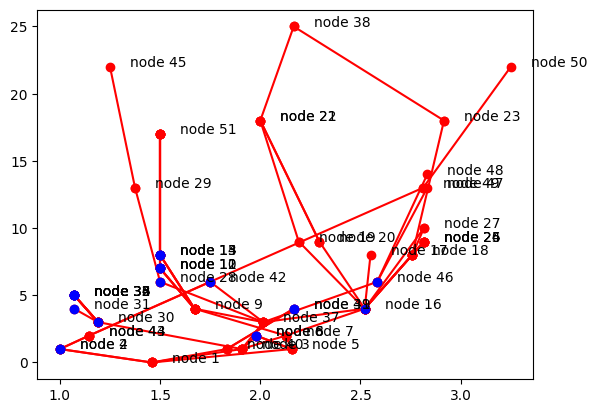

In [202]:
rrr3 = adjust_horisontal(rrr2, 0.5)
draw1(rrr3)

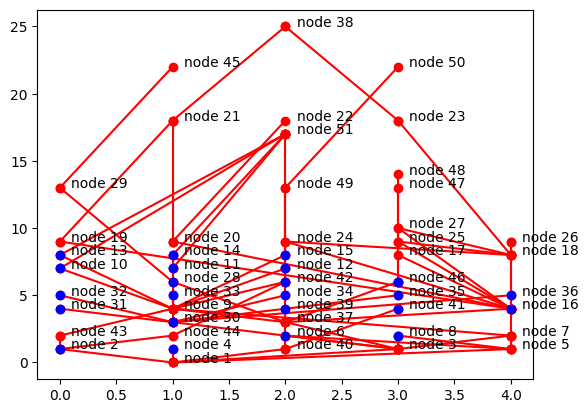

In [254]:
rrr4 = normalize_cols(rrr3)
draw1(rrr4)

Still not perfect, yet with a slighlty less edge mess in the middle comparing to `rrr1` (layers 3-6, 10-20).

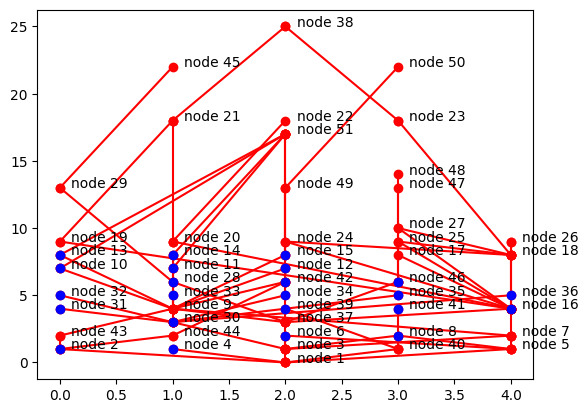

In [255]:
draw1(normalize_cols(adjust_horisontal(rrr3, 0.5)))

No significant improvement after the third `adjust_horisontal`. Two adjustments seem to be almost enough.

## Vertical adjustment?

We could also try to use force-based approach to swap some nodes between layers. It's a more complex task, comparing to horisontal adjustment. First, a number of goals on each layer could not excess the limit. So, we couldn't move a node up or down for free. Instead, it must exchange place with some another node on the target layer. Next, move of a single node affects all other nodes it's connected to. After a move, some of them could also leave current local optimum and could demand position recalculation. Effectively, we couldn't optimize vertical positions locally (opposing to horisontal positions), such activity must be global for the whole graph.

Probably, a formula for the spring potential energy could be useful here:

    E_p = kx^2 / 2

Value of `k` may depend on the edge type: higher for `EdgeType.PARENT`, lower for `EdgeType.BLOCKER`. First, we calculate a "current energy" as a sum of "energies" of all edges (`x=0` when nodes are on the neighbour layers, `x=1` when there's a 2-layer difference, and so on). Then, we try to exchange _some_ node pair, recalculate energies for all connected edges and compare with the current value. Only if new value is lower than the current, exchange is approved.

An interesting idea: what if adjustment follows selection? Instead of optimizing a whole tree, we could only try to perform adjustment to the currently selected node, making connected nodes a bit closer to it. Currently, rendering doesn't depend on selection.

In [268]:
def sign(x):
    return 0 if x == 0 else (1 if x > 0 else -1)

def force(vec, k):
    return sign(vec) * k * (abs(vec) - 1) * (abs(vec) - 1)

In [270]:
goal_layers = {t[0]: t[1]['row'] for t in rrr4.goals()}
goal_connects = {g_id: [] for g_id in goal_layers}
for row in rrr4.rows:
    for e in row.edges:
        my_id = row.goal_id
        my_layer = goal_layers[my_id]
        strength = 1.0 if e[1] == EdgeType.PARENT else 0.6
        its_id = e[0]
        its_layer = goal_layers[its_id]
        goal_connects[my_id].append((its_id, its_layer - my_layer, strength, force(its_layer - my_layer, strength)))
        goal_connects[e[0]].append((my_id, my_layer - its_layer, strength, force(my_layer - its_layer, strength)))

goal_connects

{1: [(2, 1, 1.0, 0.0),
  (3, 1, 1.0, 0.0),
  (4, 1, 1.0, 0.0),
  (5, 1, 1.0, 0.0),
  (40, 1, 1.0, 0.0)],
 2: [(1, -1, 1.0, -0.0), (43, 1, 1.0, 0.0), (44, 1, 1.0, 0.0)],
 3: [(1, -1, 1.0, -0.0),
  (6, 1, 0.6, 0.0),
  (7, 1, 0.6, 0.0),
  (8, 1, 0.6, 0.0),
  (30, 2, 1.0, 1.0),
  (37, 2, 1.0, 1.0)],
 4: [(1, -1, 1.0, -0.0)],
 5: [(1, -1, 1.0, -0.0), (6, 1, 1.0, 0.0), (7, 1, 1.0, 0.0), (8, 1, 1.0, 0.0)],
 6: [(3, -1, 0.6, -0.0), (5, -1, 1.0, -0.0)],
 7: [(3, -1, 0.6, -0.0),
  (5, -1, 1.0, -0.0),
  (9, 2, 0.6, 0.6),
  (16, 2, 0.6, 0.6)],
 8: [(3, -1, 0.6, -0.0), (5, -1, 1.0, -0.0)],
 9: [(7, -2, 0.6, -0.6),
  (10, 3, 1.0, 4.0),
  (11, 3, 1.0, 4.0),
  (12, 3, 1.0, 4.0),
  (13, 4, 1.0, 9.0),
  (14, 4, 1.0, 9.0),
  (15, 4, 1.0, 9.0),
  (37, -1, 1.0, -0.0)],
 10: [(9, -3, 1.0, -4.0), (51, 10, 0.6, 48.599999999999994)],
 11: [(9, -3, 1.0, -4.0), (51, 10, 1.0, 81.0)],
 12: [(9, -3, 1.0, -4.0), (51, 10, 0.6, 48.599999999999994)],
 13: [(9, -4, 1.0, -9.0), (51, 9, 0.6, 38.4)],
 14: [(9, -4, 1.0, -9.

In [276]:
forces = {k: sum(t[-1] for t in v) for k, v in goal_connects.items()}
print("forces:", forces)
print("total energy:", sum(abs(v) for v in forces.values()))

forces: {1: 0.0, 2: 0.0, 3: 2.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 1.2, 8: 0.0, 9: 38.4, 10: 44.599999999999994, 11: 77.0, 12: 44.599999999999994, 13: 29.4, 14: 29.4, 15: 29.4, 16: 122.4, 17: -9.0, 18: 72.6, 19: 22.4, 20: 112.0, 21: -80.80000000000001, 22: -64.0, 23: -45.0, 24: -16.0, 25: -16.0, 26: -16.0, 27: -25.6, 28: 32.0, 29: 28.0, 30: 4.0, 31: 0.0, 32: -1.0, 33: -1.0, 34: -1.0, 35: -1.0, 36: -1.0, 37: 11.0, 38: -57.599999999999994, 39: -4.0, 40: 6.4, 41: -2.4, 42: 21.200000000000003, 43: 5.3999999999999995, 44: 5.3999999999999995, 45: -64.0, 46: 81.0, 47: -36.0, 48: -49.0, 49: 28.0, 50: -64.0, 51: -293.4}
total energy: 1695.6000000000004
